In [1]:
import os
import re
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import datetime
from typing import Union

from wordcloud import WordCloud, STOPWORDS

In [2]:
sns.set_theme(style="whitegrid",font_scale=2)

## Analyze All Data

In [3]:
file_list = os.listdir(os.path.abspath('./data'))
csv_files = [k for k in file_list if '.csv' in k]
print(csv_files)

df = pd.concat([pd.read_csv("".join(['./data/',f]),index_col=0) for f in csv_files ], ignore_index=True)

['aero.csv', 'stanford.csv', 'csem2.csv', 'csem1.csv']


### Cleanup some parts

In [4]:
# scraping may have resulted in some duplicates (e.g. result match multiple search)
# it is ok to casually drop duplicates because timestamps included ensures uniqueness
df = df.drop_duplicates()

In [5]:
df['decdate'].fillna(df['date_add'], inplace=True)
df['decdate_ts'].fillna(df['date_add_ts'], inplace=True)
df['decdate_ts'] = df['decdate_ts'].astype('int')

df['major'] = df['major'].replace(
    'Computational Sciences, Engineering And Mathematics (CSEM) (Computational Sciences, Engineering And Mathematics (CSEM))',
    'Computational Sciences, Engineering And Mathematics (CSEM)')
df['major'] = df['major'].replace(
    'Computational Sciences, Engineering And Mathematics (CSEM)(Computational Sciences, Engineering And Mathematics (CSEM))',
    'Computational Sciences, Engineering And Mathematics (CSEM)')

In [6]:
def vec_dt_replace(series, year=None, month=None, day=None):
    return pd.to_datetime(
        {'year': series.dt.year if year is None else year,
         'month': series.dt.month if month is None else month,
         'day': series.dt.day if day is None else day})

In [7]:
df_1720 = df[(df['season'].isin(['Fall 2018', 'Fall 2019', 'Fall 2020', 'Fall 2021','Fall 2022','Fall 2023']))]

In [8]:
df.columns

Index(['institution', 'major', 'degree', 'season', 'decisionfin', 'method',
       'decdate', 'decdate_ts', 'gpa', 'grev', 'greq', 'greaw', 'status',
       'date_add', 'date_add_ts', 'comment'],
      dtype='object')

### Make it easier to filter through programs using the decision, the institution, gre, gpa, etc.

In [9]:
def create_filter(df,
                  degree: str = None,
                  decisionfin: Union[str, list] = None,
                  institution: Union[str, list] = None,
                  prog: Union[str,list] = None,
                  gpa: bool = False):
    filt = [True] * len(df)
    if degree is not None:
        filt = (filt) & (df['degree'] == degree)
    if prog is not None:
        filt = (filt) & (df['major'].astype(str).str.contains(prog))
    if decisionfin is not None:
        if isinstance(decisionfin, str):
            filt = (filt) & (df['decisionfin'].str.contains(decisionfin, case=False))
        elif isinstance(decisionfin, list):
            filt = (filt) & (df['decisionfin'].isin(decisionfin))
    if institution is not None:
        if isinstance(institution, str):
            filt = (filt) & (df['institution'].str.contains(institution, case=False))
        elif isinstance(institution, list):
            filt = (filt) & (df['institution'].isin(institution))
    if gpa:
        filt = (filt) & (~df['gpa'].isna()) & (df['gpa'] <= 4)
    
    return filt

### Actual function that generates the images

In [10]:
def get_uni_stats(u_df, 
                  histype: str = None, 
                  search: str = None, 
                  major: str = None,
                  title: str = None, 
                  degree: str = '', 
                  field: str = '', 
                  hue='decisionfin'
                 ):
    title = title if title is not None else search
    if degree not in ['MS', 'PhD', 'MEng', 'MFA', 'MBA', 'Other']:
        degree = 'Other'
        
    # Clean up the data a bit, this probably needs a lot more work
    # Maybe its own method, too
    u_df = u_df.copy()
    u_df = u_df[~u_df['decdate'].isna()]
    u_df.loc[:,'year'] = u_df['decdate'].str[-4:].astype(int)
    u_df = u_df[(u_df['year'] > 2000) & (u_df['year'] < datetime.datetime.now().year)]
    
    # Normalize to 2020. 2020 is a good choice because it's recent AND it's a leap year
    u_df.loc[:, 'uniform_dates'] = vec_dt_replace(pd.to_datetime(u_df['decdate'],dayfirst=True), year=2020)
    
    # Get december dates to be from "2019" so Fall decisions that came in Dec come before the Jan ones.
    dec_filter = u_df['uniform_dates'] > datetime.datetime.strptime('2020-11-30', '%Y-%m-%d')
    u_df.loc[dec_filter, 'uniform_dates'] = vec_dt_replace(pd.to_datetime(u_df[dec_filter]['uniform_dates']), year=2019)

    # Trying to pick red/green colorblind-friendly colors
    flatui = ["#00A36C", "#C21E56", "#FFC300"]
    sns.set_palette(flatui)
    acc_patch = mpatches.Patch(color='#00A36C80')
    rej_patch = mpatches.Patch(color='#C21E5680')
    int_patch = mpatches.Patch(color='#FFC30080')
    acc_line = mlines.Line2D([], [], color='#00A36C')
    rej_line = mlines.Line2D([], [], color='#C21E56')
    int_line = mlines.Line2D([], [], color='#FFC300')
    
    status_type = ['Accepted', 'Rejected', 'Interview']

    hue_order = status_type
    
    if hue == 'status':
        hue_order = ['American', 'International', 'Other']
        status_type = ['Accepted', 'Interview']
    
    # No more GRE, so we do 2x1
    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    # Timeline stats
    mscs_filt = create_filter(u_df, degree, status_type, institution = search, prog = major)
    mscs_filt = (mscs_filt) & (u_df['uniform_dates'].astype(str) <= '2020-06-00')
    
    if histype == 'ecdf':
        stat = "count"
        sns.ecdfplot(data=u_df[mscs_filt],
                     x='uniform_dates',
                     stat=stat,
                     hue=hue,
                     hue_order=hue_order,
                     ax=ax[0]
                    )
    else:
        sns.histplot(data=u_df[mscs_filt],
                     x='uniform_dates',
                     element='step',
                     hue=hue,
                     cumulative=True,
                     discrete=False,
                     fill=False,
                     hue_order=hue_order,
                     ax=ax[0]
                    )

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.formats = ['%b',  # years
                         '%b',       # months
                         '%d',       # days
                         '%H:%M',    # hrs
                         '%H:%M',    # min
                         '%S.%f', ]  # secs
    # Hide the year
    formatter.zero_formats = ['%b',  # years
                         '%b',       # months
                         '%d',       # days
                         '%H:%M',    # hrs
                         '%H:%M',    # min
                         '%S.%f', ]  # secs
    # Hide the year
    formatter.offset_formats = ['',  # years
                         '',       # months
                         '%d',       # days
                         '%H:%M',    # hrs
                         '%H:%M',    # mins
                         '%S.%f', ]  # secs
    
    ax[0].xaxis.set_major_locator(locator)
    ax[0].xaxis.set_major_formatter(formatter)
    h, l = ax[0].get_legend_handles_labels()
    
    # Add frequency counts
    if h is not None and l is not None:
        if hue == 'decisionfin':
            counts = u_df[mscs_filt][hue].value_counts().reindex(hue_order)
            l = [f'{value} (n={count})' for value, count in counts.items()]
            ax[0].legend(handles=[acc_line, rej_line, int_line], labels=l, title="Decision")

    ax[0].set_xlabel("Date")
    ax[0].set_ylabel("Count")
    ax[0].set_title("Cumsum of decisions")
    
    # Get GPA stats
    mscs_filt = create_filter(u_df, degree, status_type, institution = search, prog = major, gpa = True)
    sns.histplot(data=u_df[mscs_filt],
                 multiple="stack",
                 x='gpa',
                 hue=hue,
                 hue_order=hue_order,
                 bins=20,
                 ax=ax[1]
                )
    ax[1].set_xlabel("GPA")
    ax[1].set_ylabel("Count")
    ax[1].set_title("GPA Distribution")
    
    # Add frequency counts
    #h, l = ax[0][1].get_legend_handles_labels()
    h, l = ax[1].get_legend_handles_labels()
    if h is not None and l is not None:
        if hue == 'decisionfin':
            counts = u_df[mscs_filt][hue].value_counts().reindex(hue_order)
            l = [f'{value} (n={count})' for value, count in counts.items()]
            ax[1].legend(handles=[acc_patch, rej_patch, int_patch], labels=l, title="Decision")
    
    # Save file to output directory
    fig.suptitle(title + ', ' + field + ' ' + degree, size='xx-large')
    plt.savefig('output/' + title + '_' + field + '_' + degree + '.png')
    fig

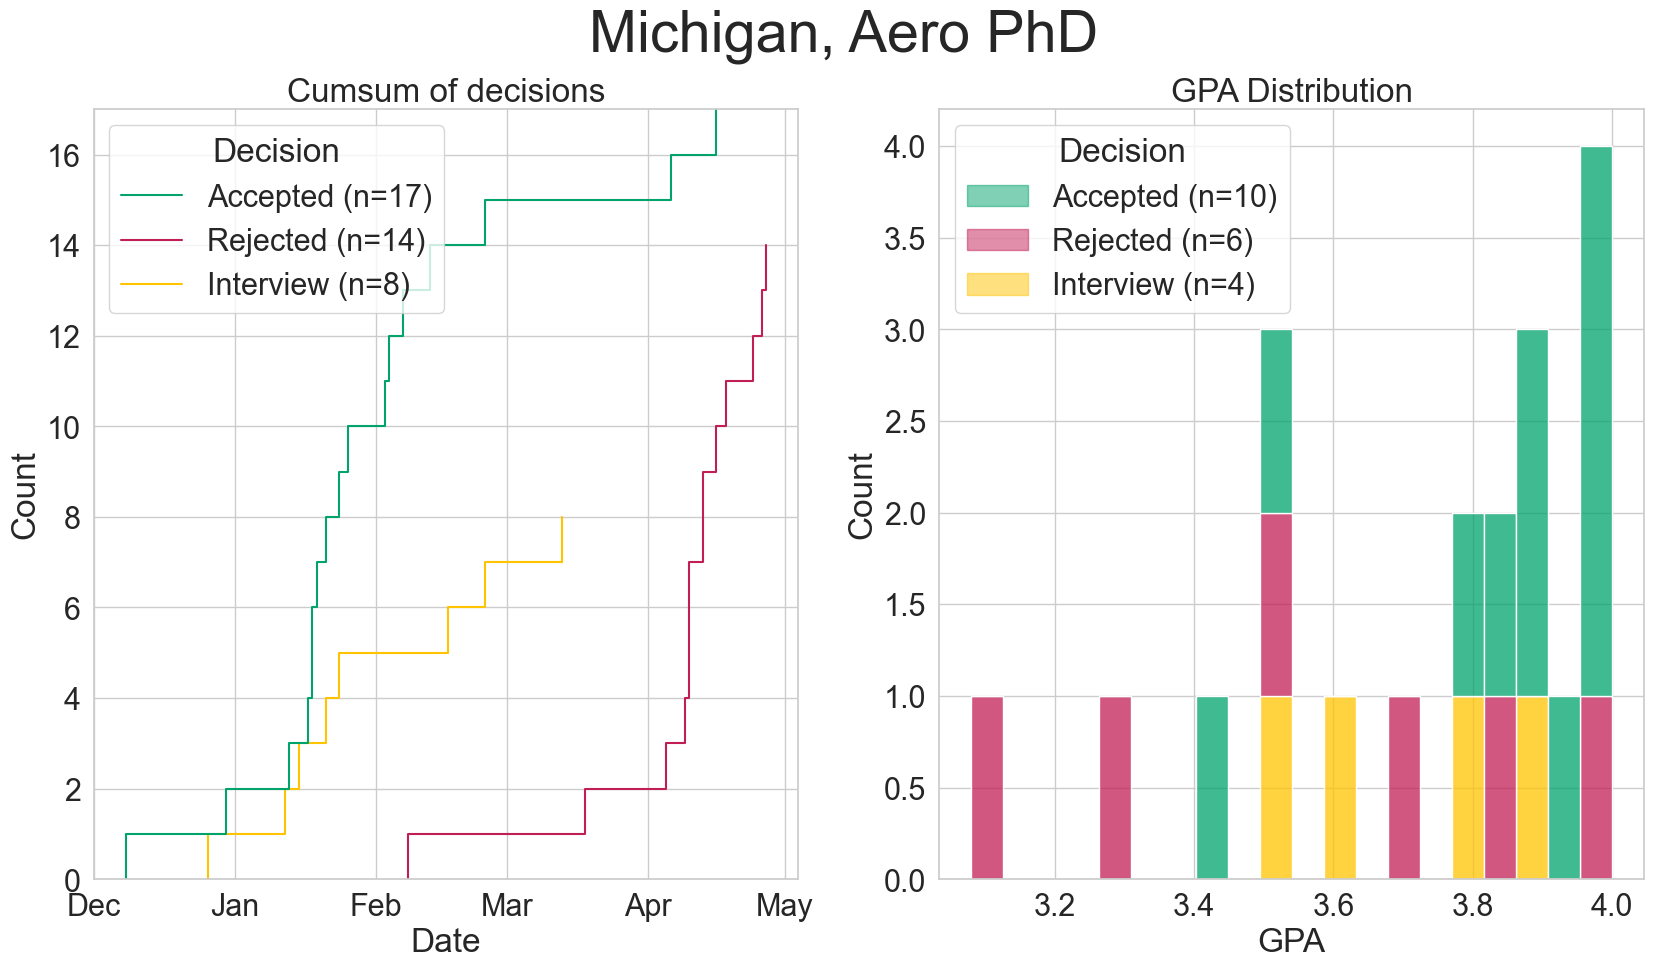

In [37]:
# Change 'search' accordingly
# histype='ecdf' for increased granularity
get_uni_stats(df_1720, histype='ecdf', search='Michigan', major='Aero', title='Michigan', degree='PhD', field='Aero')

## Other things you could analyze

For instance how many interviews per university, and thus know how likely it is that the interview process is a must if you wanna be accepted.

### Bad interview analysis

In [12]:
df_1720['is_int'] = 0

In [13]:
df_1720.loc[df_1720['decisionfin'] == 'Interview', 'is_int'] = 1

In [14]:
df_1720.groupby(by='institution').agg({'is_int': sum}).sort_values(by='is_int', ascending=False).head(10)

,is_int
institution,
Stanford University,33
Princeton University,19
"University of Colorado, Boulder",8
University of Michigan (Ann Arbor),8
University Of Washington,7
Georgia Institute Of Technology,7
University Of Toronto,6
University Of Southern California,5
Massachusetts Institute Of Technology (MIT),5


# Analyze other fields

In [27]:
#hisdf = pd.read_csv("data/all.csv", index_col=0, low_memory=False)

# Here we filter out old GRE scores so that it does not mess up the box plots
hisdf = df[((df['greq'] <= 170) | (df['greq'].isnull())) & ((df['grev'] <= 170) | (df['grev'].isnull()))]

In [28]:
hisdf.columns

Index(['institution', 'major', 'degree', 'season', 'decisionfin', 'method',
       'decdate', 'decdate_ts', 'gpa', 'grev', 'greq', 'greaw', 'status',
       'date_add', 'date_add_ts', 'comment'],
      dtype='object')

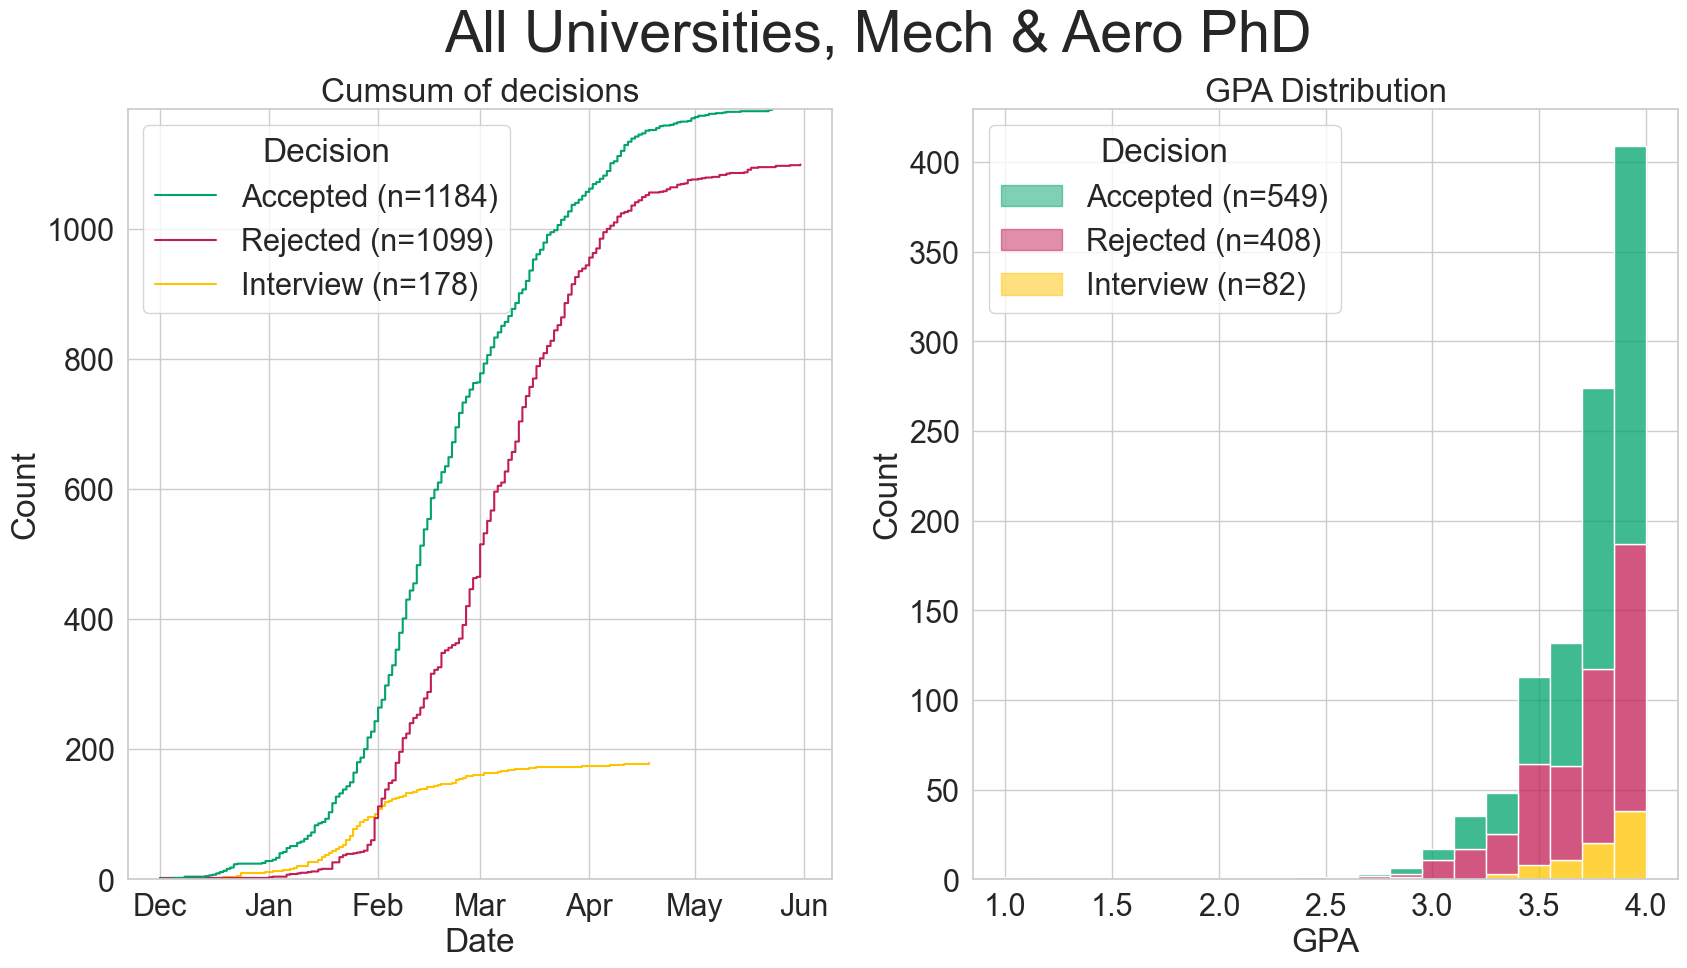

In [29]:
get_uni_stats(hisdf, histype='ecdf', title='All Universities', degree='PhD', field='Mech & Aero')

## Answering Questions

### GPA Inflation

In [30]:
hisdf['decyear'] = hisdf['decdate'].str.slice(-4)
hisdf['decyear'] = (hisdf['decyear'].str[2:]).astype(int)
hisdf = hisdf[(hisdf['decyear'] >= 9) & (hisdf['decyear'] <= 23) & (hisdf['gpa'] <= 4)]
gpadf = hisdf[~hisdf['decyear'].isnull()].groupby(by=['decyear']).agg({'gpa': 'mean'})

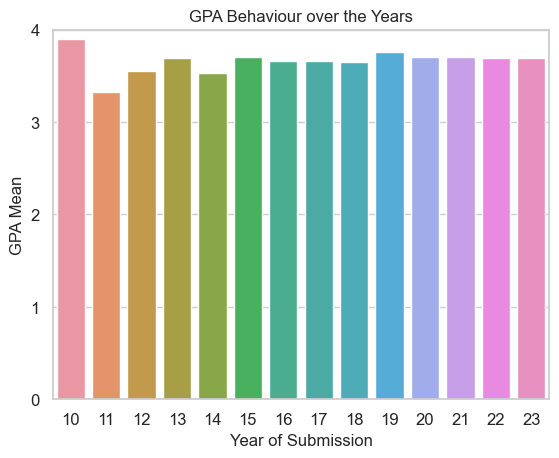

In [31]:
fig, ax = plt.subplots()
sns.barplot(x = gpadf.index,
            y=gpadf['gpa'],
            ax=ax)
ax.set_ylim([0, 4])
ax.set_xlabel("Year of Submission")
ax.set_ylabel("GPA Mean")
ax.set_title("GPA Behaviour over the Years")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.show()

In [32]:
fig.savefig("output/gpa_inflation.png")

### Do International Students Have Significantly Different Stats?

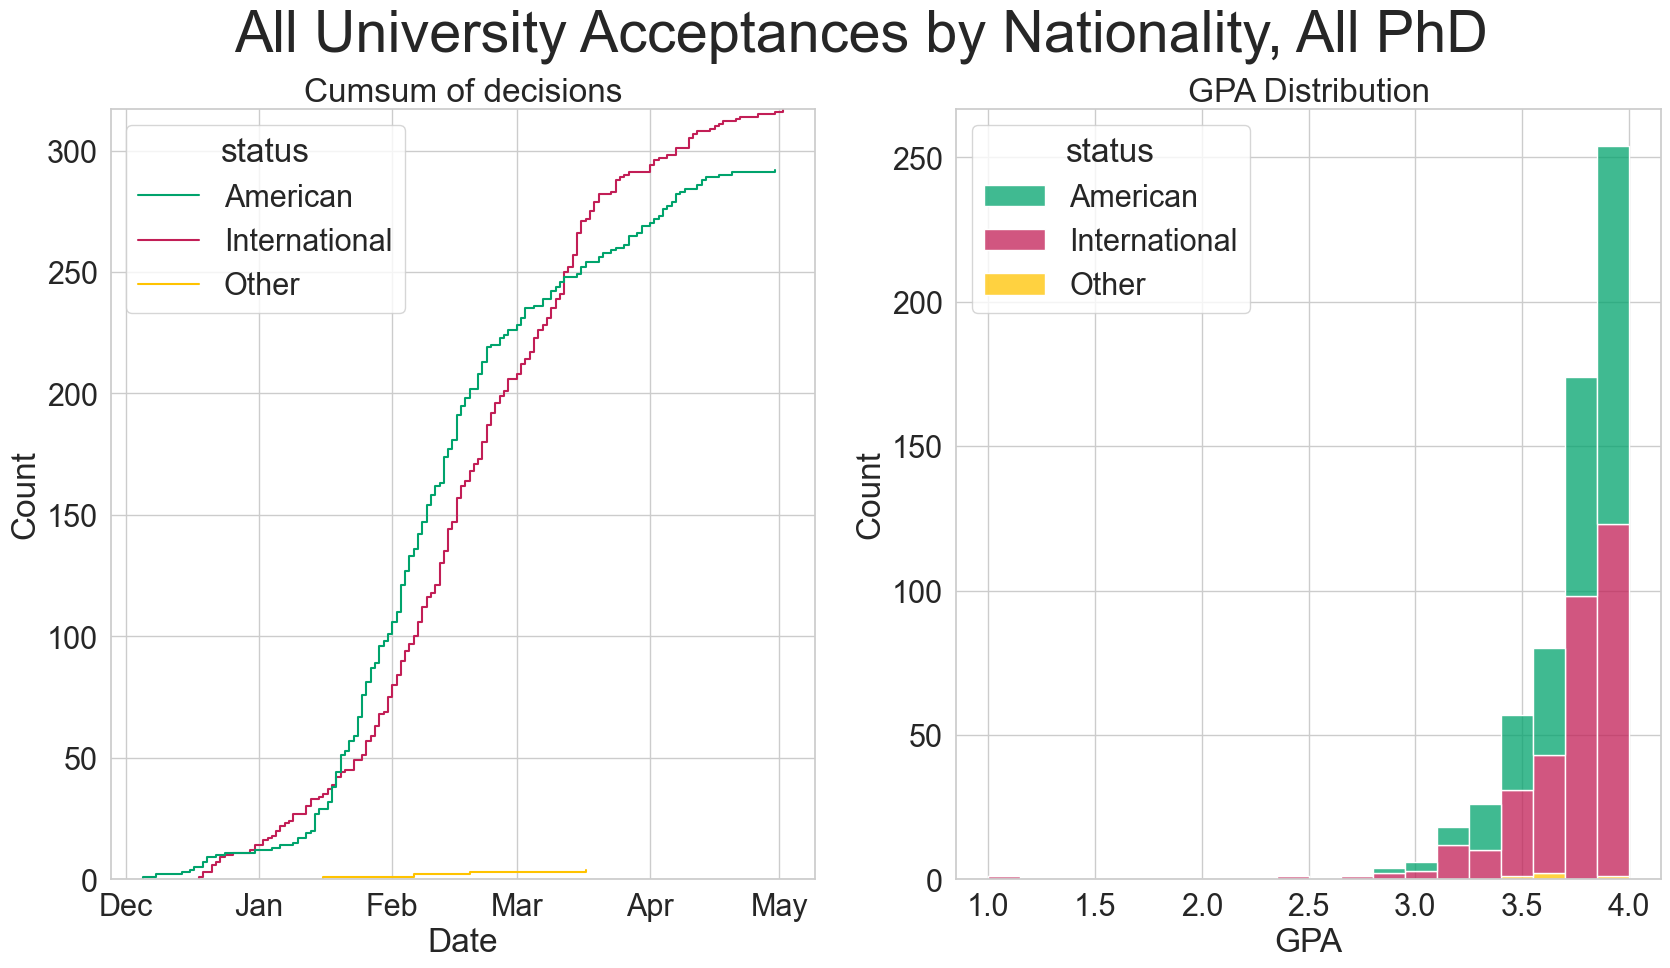

In [33]:
get_uni_stats(hisdf, histype='ecdf', title='All University Acceptances by Nationality', degree='PhD', field='All', hue='status')

### Comment analysis

This helps to visualize what people are saying most often about the program admission

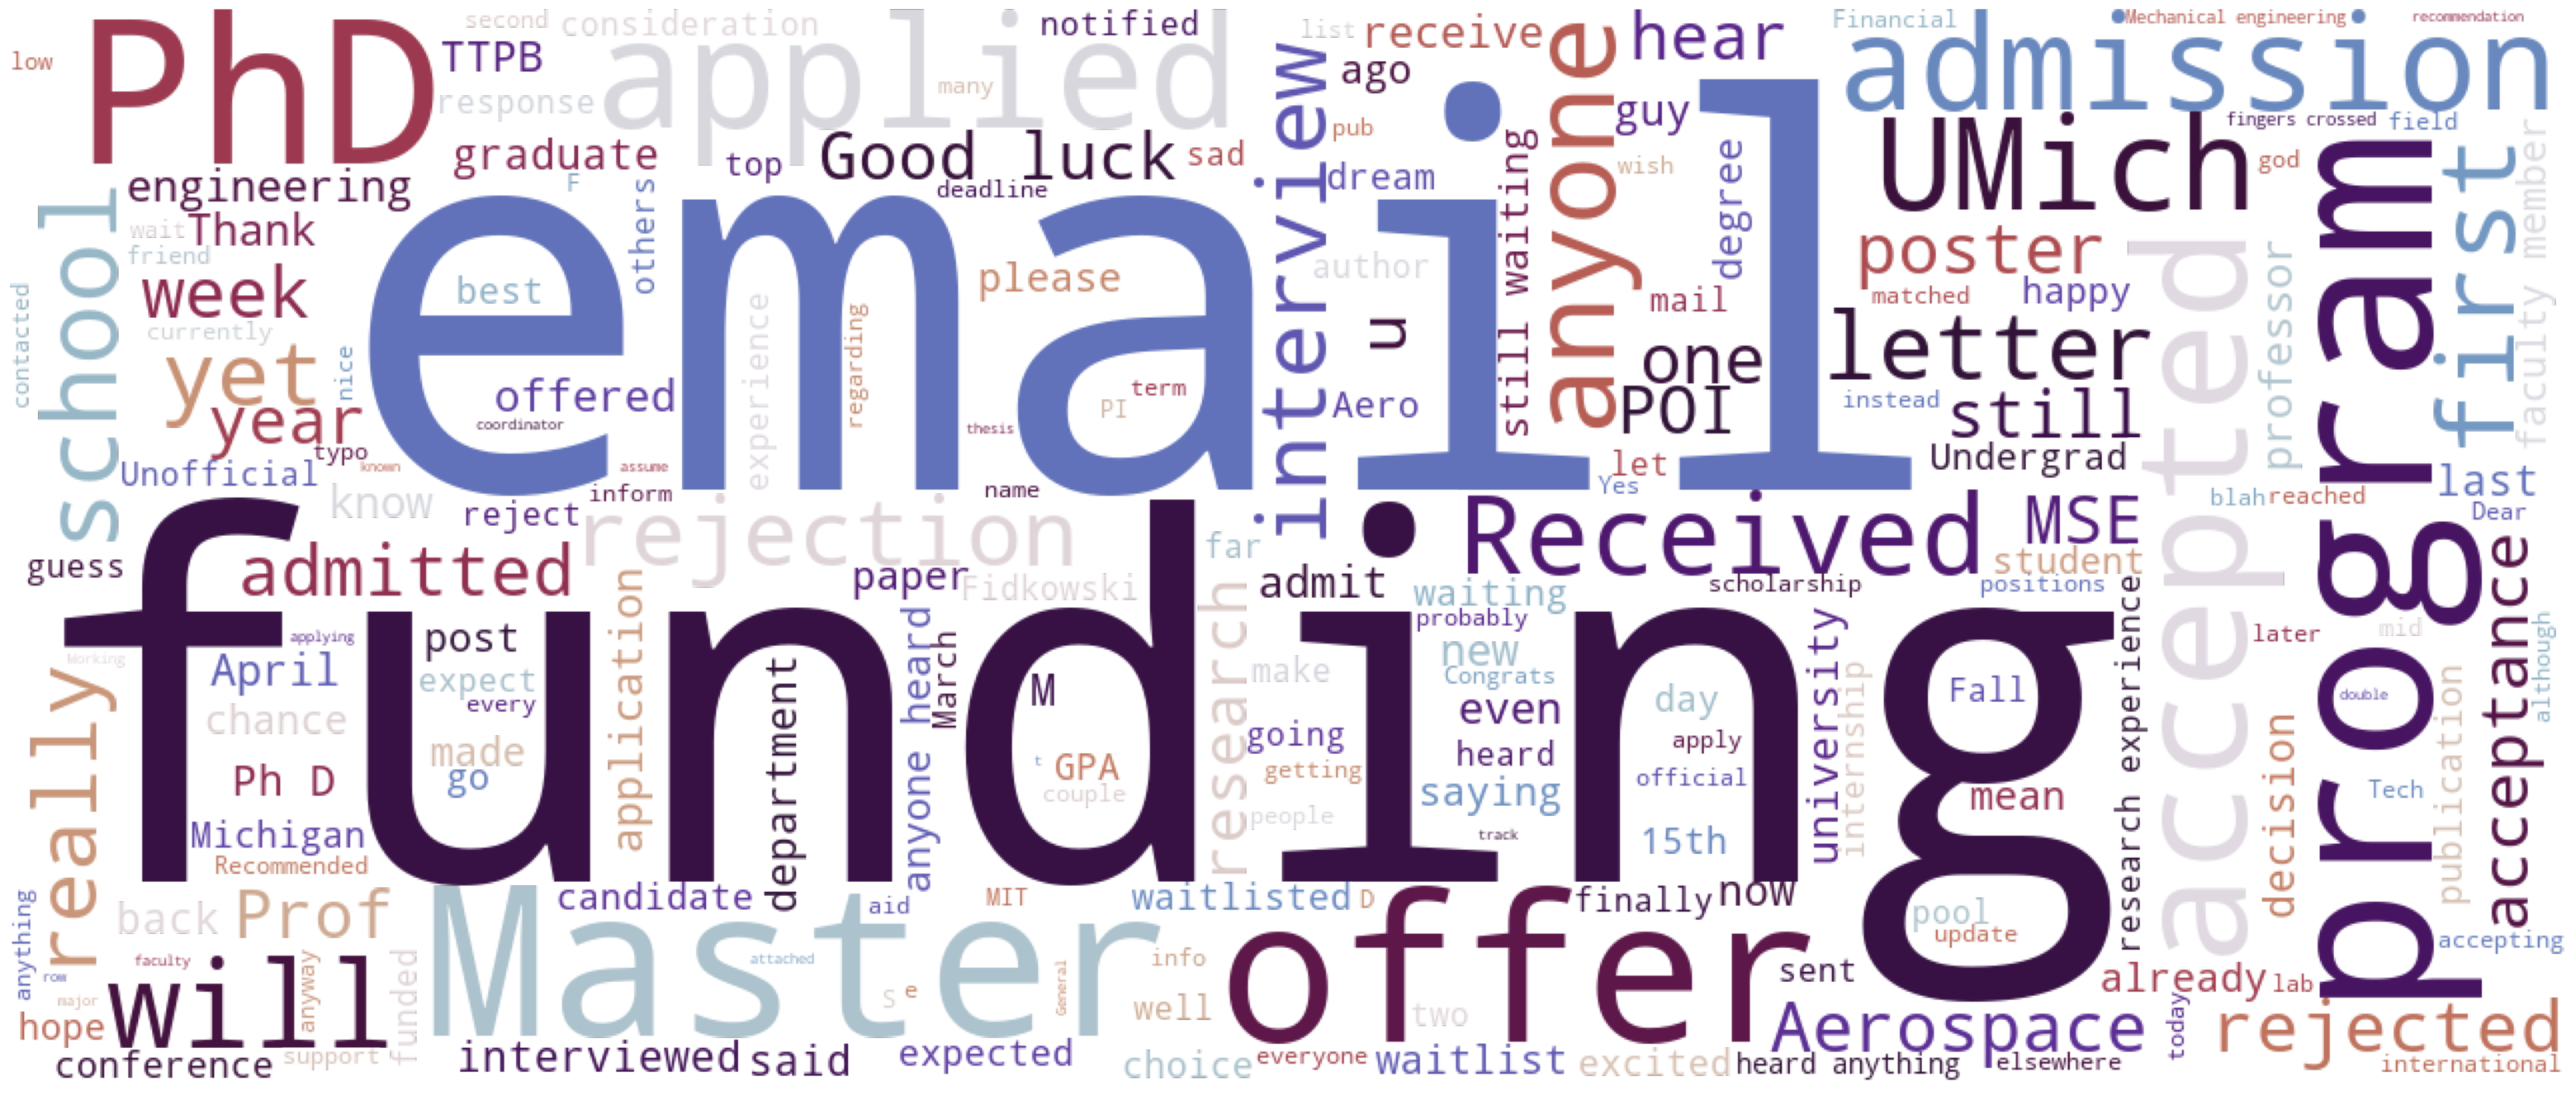

In [38]:
# function to plot wordcloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
    plt.savefig("output/wordcloud.png")

# if you want for a specific school/program then filter the df accordingly
cdf = df.loc[(df['institution'].astype(str).str.contains("Michigan"))&(df['major'].astype(str).str.contains("Aero"))]

# concat all the comments into a text chunk and clean it up
text = cdf.dropna(subset=['comment'])['comment'].str.cat(sep=' ')
text = re.sub(r'==.*?==+', '', text)
text = text.replace('\n', '')

# add some stopwords
STOPWORDS.update(['got','though'])
    
# print the wordcloud
wordcloud = WordCloud(width=1280,
                      height=540,
                      mode="RGBA",
                      background_color=None,
                      colormap="twilight",
                      max_font_size=270,
                      random_state=1,
                      collocations=True,
                      stopwords=STOPWORDS
                     ).generate(text)
plot_cloud(wordcloud)

### List of majors in the dataset

In [35]:
pd.options.display.max_rows = 200
hisdf['major'].value_counts()

Aerospace Engineering                                                             828
Mechanical And Aerospace Engineering                                              237
Aerospace And Mechanical Engineering                                               84
Aeronautics/Aerospace Engineering                                                  79
Aerospace                                                                          71
Mechanical Engineering                                                             69
Aeronautics And Astronautics                                                       60
Aerospace & Mechanical Engineering                                                 54
Aeronautics & Astronautics                                                         52
Computational Sciences, Engineering And Mathematics (CSEM)                         43
Aero Astro                                                                         34
Aeronautics                                           